# **GraphMinds - Algorithmic Exploration of Network Communities**

<h2>
Name: Ayushman Anupam
</h2>

### Importing needed libraries

In [1]:
import os
import warnings
import pickle
import itertools
import operator
from collections import Counter
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from joblib import Parallel, delayed
from tqdm import tqdm
import networkx as nx
from scipy.linalg import eigh
from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering

from networkx.algorithms.community import (
    louvain_communities,
    label_propagation_communities,
)
from networkx.algorithms.community.quality import modularity

# === Environment Setup (Fix Windows & MKL Issues) ===
os.environ["OMP_NUM_THREADS"] = "2"        # Prevent MKL/KMeans thread issues
os.environ["LOKY_MAX_CPU_COUNT"] = "4"     # Avoid CPU core detection warnings

warnings.filterwarnings("ignore", message="Could not find the number of physical cores")
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
edge_list_path = "data/Email-Enron.txt"
G = nx.read_edgelist(edge_list_path, create_using=nx.Graph())
print(f"Total number of Nodes: {G.number_of_nodes()}")
print(f"Total number of Edges: {G.number_of_edges()}")

Total number of Nodes: 36692
Total number of Edges: 183831


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

# **1. About Dataset**

The **Enron Email Dataset** represents the email communication network among employees of the **Enron Corporation**, a U.S. energy company that collapsed in 2001 due to a major accounting scandal.
It was originally made public by the **Federal Energy Regulatory Commission (FERC)** during its investigation and is hosted by the **Stanford SNAP project**.

* **Dataset Name:** Email-Enron Network
* **Source:** [http://snap.stanford.edu/data/email-Enron.html](http://snap.stanford.edu/data/email-Enron.html)
* **Type:** Graph / Network dataset
* **Nodes:** 36,692 (each node is an email address)
* **Edges:** 183831 (an edge indicates that at least one email was exchanged between two addresses)
* **Nature:** Undirected graph — if person *i* sent an email to *j*, an undirected edge (i, j) is created.
* **Format:** Text file with two columns — `FromNodeId` and `ToNodeId`.

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

# **2. Problem Statement and Solution**
## **Objective**

To perform **community detection** on the Enron email network to identify groups of employees who communicate frequently with each other, potentially reflecting organizational units, work teams, or social clusters.

### **Solution Approach**

1. **Data Representation:**
   Model the email exchanges as a **graph**, where nodes represent email IDs and edges represent communication links.

2. **EDA and Graph Construction:**
3. **Community Detection using different Algorithms:**
4. **Analysis:**
   * Compute metrics like modularity, number of detected communities, and average cluster size.
   * Visualize major communities and interpret communication patterns.

5. **Conclusion and Result**

In [ ]:
# # sub graph for testing puposes

# full_edge_list_path = "data/Email-Enron.txt"
# edge_list_path = "data/Email-Enron-Subset.txt"

# # --- Create a smaller edge list file (first 20,000 edges) ---
# with open(full_edge_list_path, "r") as fin, open(edge_list_path, "w") as fout:
#     for i, line in enumerate(fin):
#         if i >= 20000:  # stop after 20,000 edges
#             break
#         fout.write(line)

# # --- Load this smaller graph ---
# G = nx.read_edgelist(edge_list_path, create_using=nx.Graph())

# print(f"Subset Graph Loaded!")
# print(f"Total number of Nodes: {G.number_of_nodes()}")
# print(f"Total number of Edges: {G.number_of_edges()}")


Subset Graph Loaded!
Total number of Nodes: 7815
Total number of Edges: 18623


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

# 3. EDA and Graph Visualization

In [35]:
# Connected components
num_components = nx.number_connected_components(G)
print(f"Total number of Connected Components: {num_components}")

#  Degree statistics
degrees = [d for _, d in G.degree()]
avg_degree = sum(degrees) / len(degrees)
max_degree = max(degrees)
print(f"Average Node Degree: {avg_degree:.2f}")
print(f"Maximum Node Degree: {max_degree}")

# Largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc)
print(f"Largest Connected Component Size: {len(G_lcc.nodes())}")

Total number of Connected Components: 1065
Average Node Degree: 10.02
Maximum Node Degree: 1383
Largest Connected Component Size: 33696


#### Plot of **Degree distribution** of nodes of Graph

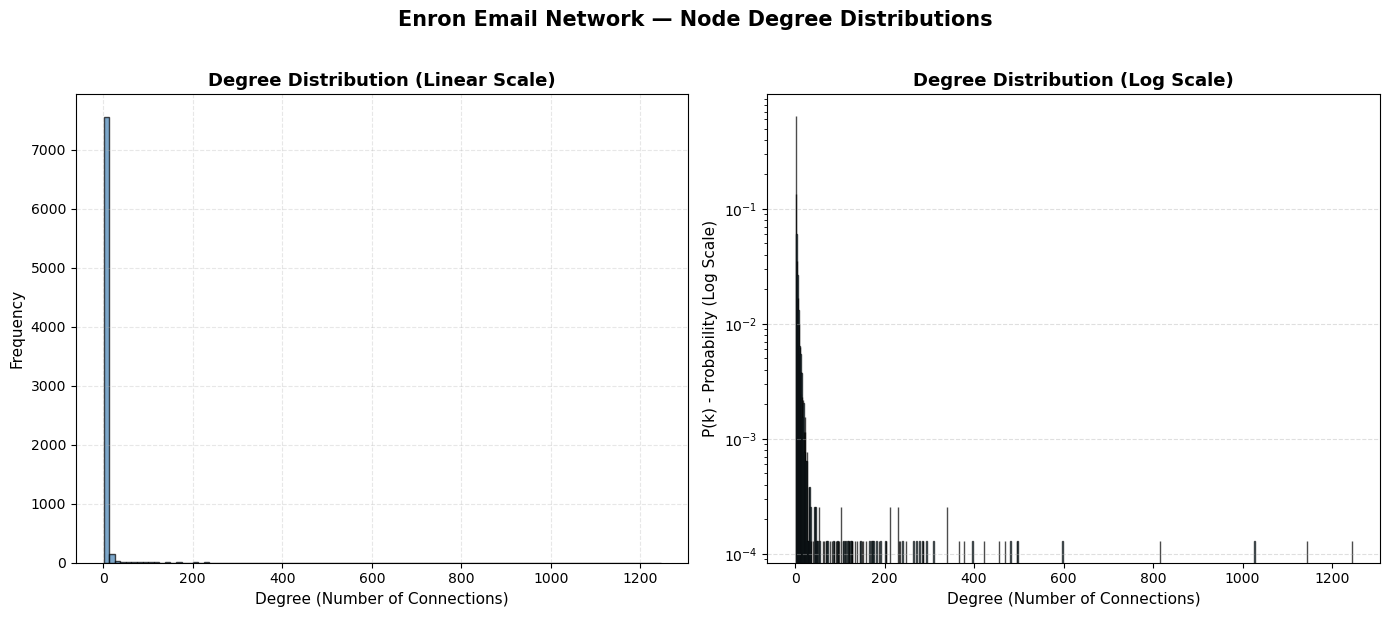

In [ ]:
# Compute Degrees ---
degrees = [d for _, d in G.degree()]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(degrees, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Degree Distribution (Linear Scale)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Degree (Number of Connections)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')

axes[1].hist(
    degrees,
    bins=range(max(degrees) + 1),
    density=True,
    log=True,
    color='skyblue',
    alpha=0.7,
    edgecolor='black'
)
axes[1].set_title('Degree Distribution (Log Scale)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Degree (Number of Connections)', fontsize=11)
axes[1].set_ylabel('P(k) - Probability (Log Scale)', fontsize=11)
axes[1].grid(axis='y', alpha=0.4, linestyle='--')
plt.suptitle("Enron Email Network — Node Degree Distributions", fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


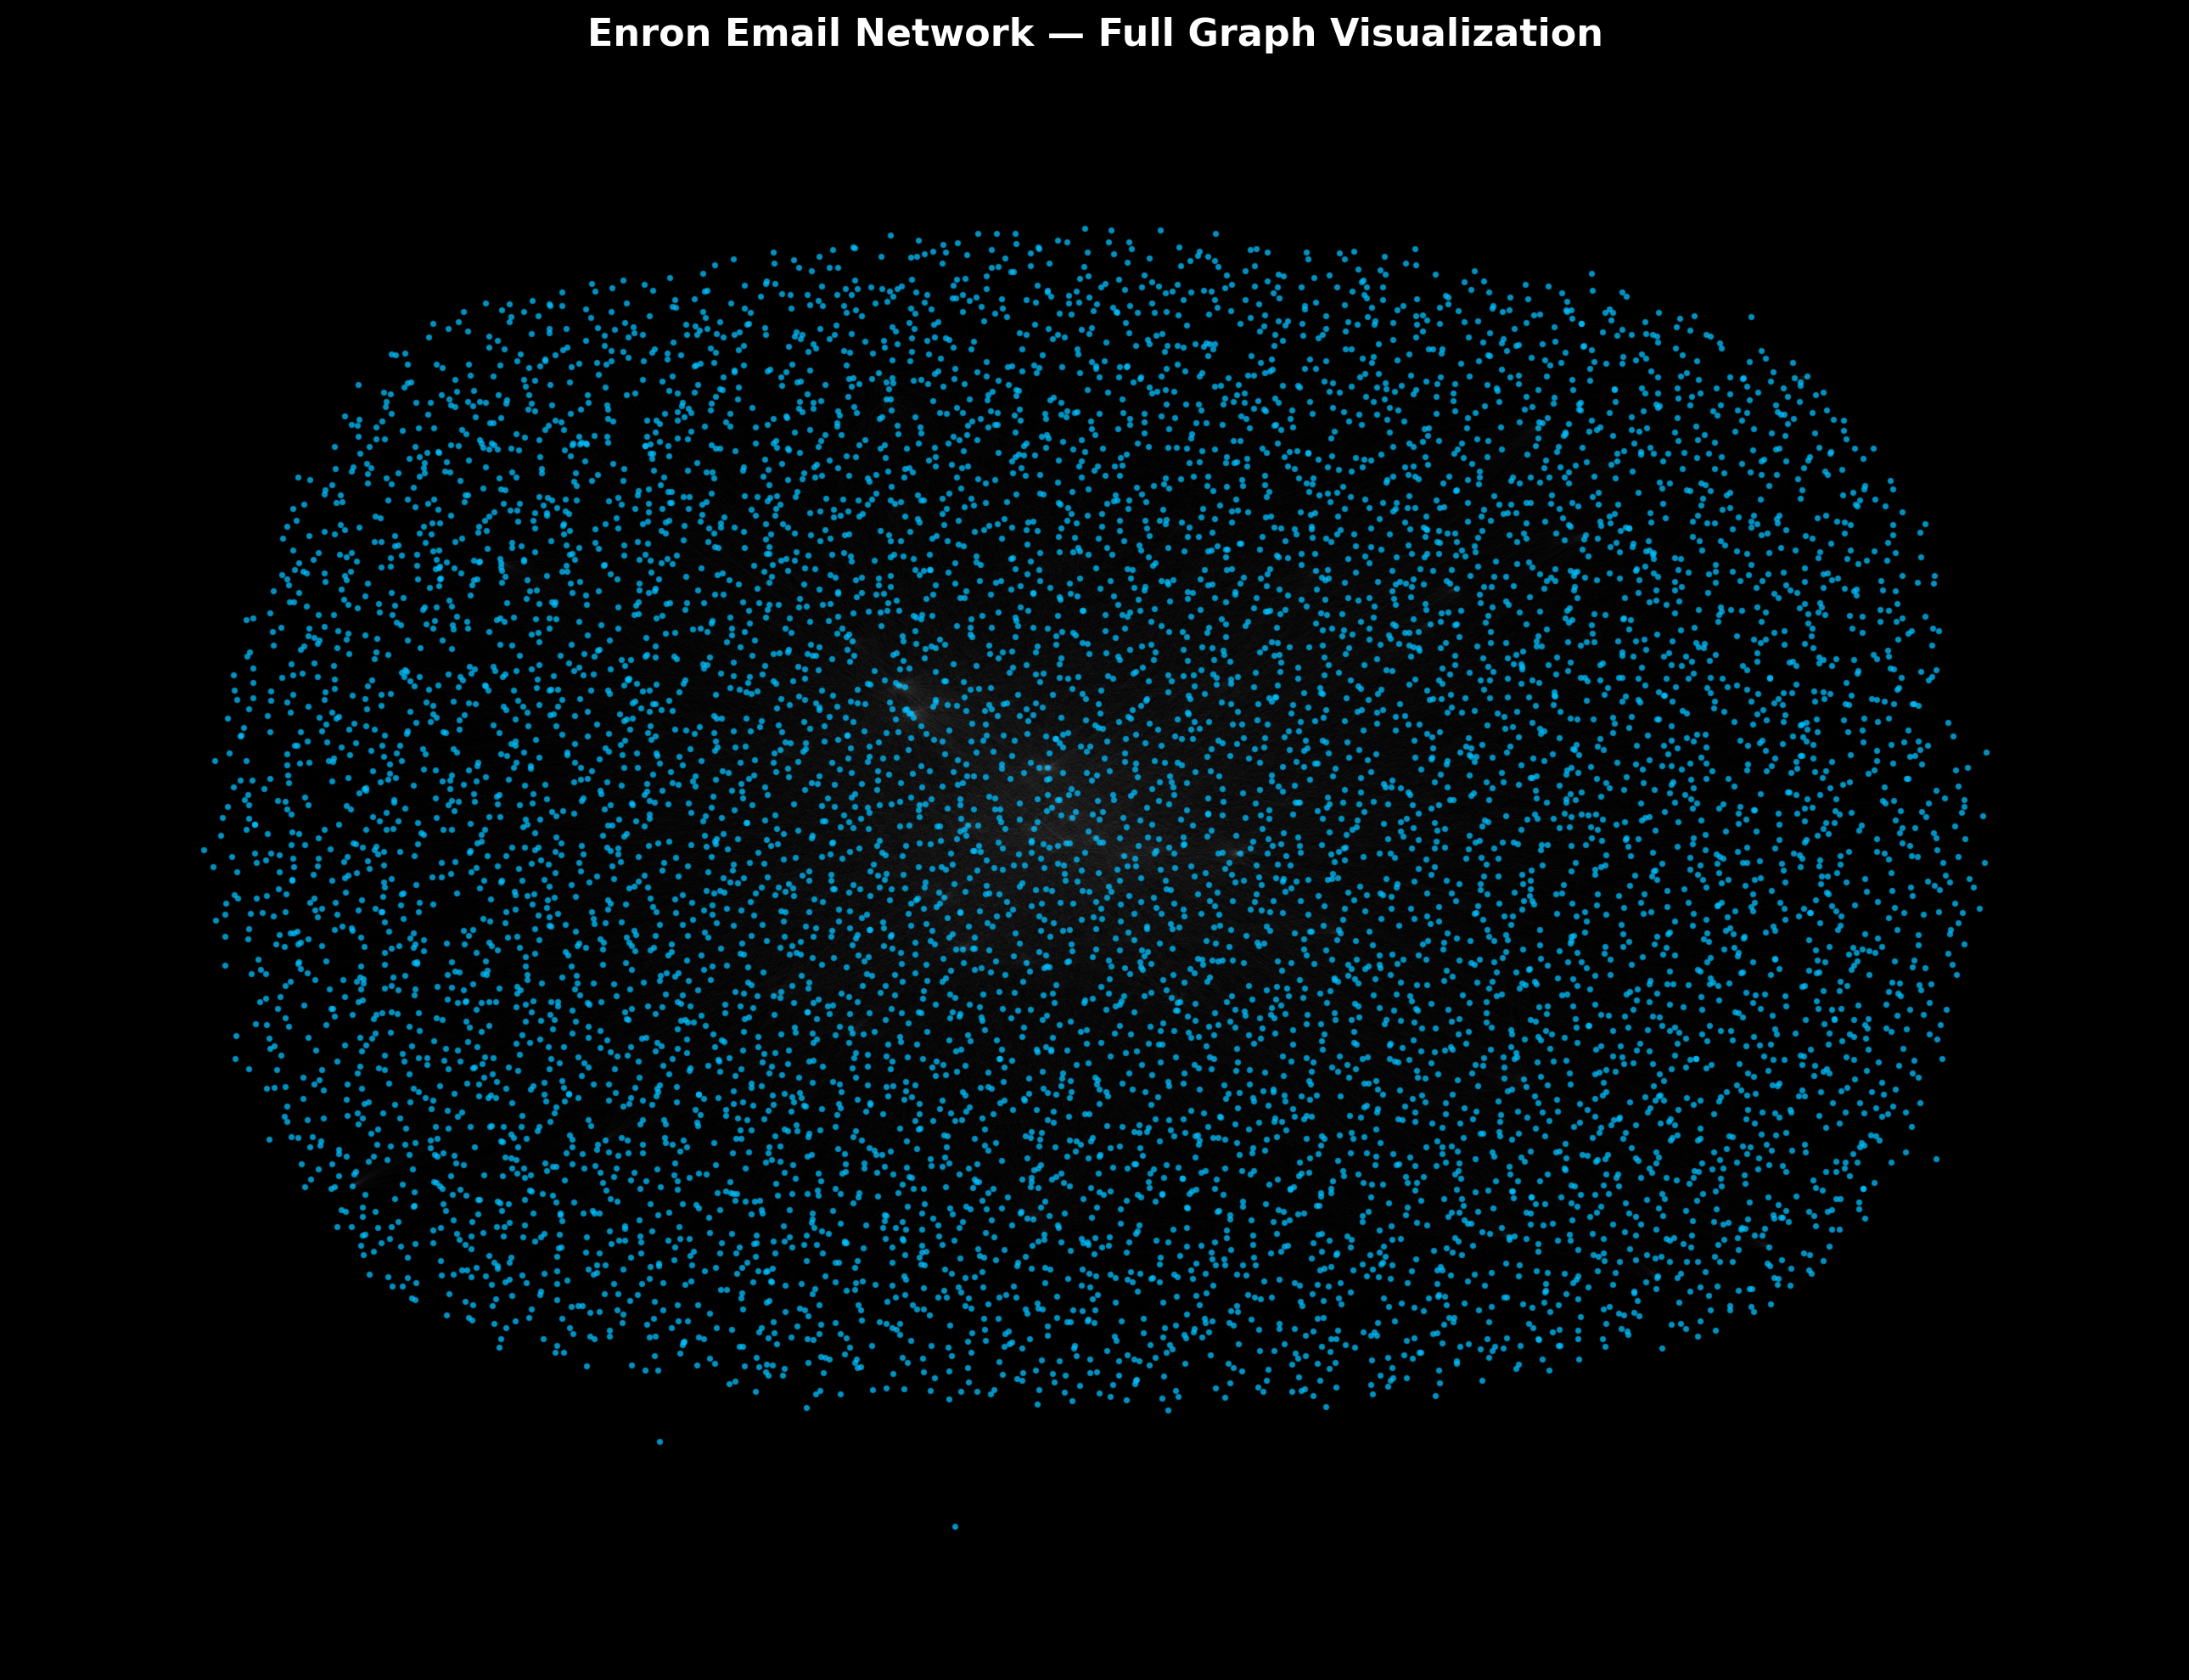

In [ ]:
# Elegant Full Enron Email Network
pos = nx.spring_layout(G, k=0.1, iterations=5, seed=42)

plt.figure(figsize=(13, 10), dpi=200, facecolor='black')
nx.draw_networkx_edges(G, pos, alpha=0.015, width=0.2, edge_color='white')
nx.draw_networkx_nodes(G, pos, node_size=3, alpha=0.6, node_color='deepskyblue')

plt.title("Enron Email Network — Full Graph Visualization", fontsize=16, fontweight='bold', color='white', pad=20)
plt.axis("off")
plt.tight_layout()
# plt.savefig("Enron_Full_Network.png", dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

In [36]:
# Degree Assortativity
assortativity = nx.degree_assortativity_coefficient(G_lcc)
print(f"Degree Assortativity Coefficient (r): {assortativity:.4f}")

if assortativity > 0:
    print("Interpretation: Positive assortativity indicates that high-degree nodes tend to connect with other high-degree nodes (typical of social networks).")
elif assortativity < 0:
    print("Interpretation: Negative assortativity suggests that high-degree nodes connect with low-degree nodes (disassortative mixing), often found in organizational or hierarchical networks.")
else:
    print("Interpretation: The network shows neutral mixing (no strong assortative pattern).")

# Approximate Clustering
def approximate_average_clustering(G, sample_size=1000):
    nodes = list(G.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    cluster_vals = [nx.clustering(G, node) for node in sampled_nodes]
    return sum(cluster_vals) / len(cluster_vals)

clustering = approximate_average_clustering(G_lcc, sample_size=1000)
print(f"\nApproximate Average Clustering Coefficient: {clustering:.4f}")

# Approximate Average Path Length
def approximate_average_path_length(G, sample_size=500):
    nodes = list(G.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    lengths = []
    for node in sampled_nodes:
        sp = nx.single_source_shortest_path_length(G, node)
        lengths.extend(sp.values())
    return sum(lengths) / len(lengths)

approx_path_len = approximate_average_path_length(G_lcc, sample_size=500)
print(f"Approximate Average Shortest Path Length : {approx_path_len:.2f}")

# Density
density = nx.density(G_lcc)
print(f"Network Density: {density:.6f}")

print("\nSummary:")
print("- Clustering Coefficient measures local tightness of connections.")
print("- Density quantifies global edge connectedness.")
print("- Average Path Length (approximated) captures communication efficiency.")

Degree Assortativity Coefficient (r): -0.1165
Interpretation: Negative assortativity suggests that high-degree nodes connect with low-degree nodes (disassortative mixing), often found in organizational or hierarchical networks.

Approximate Average Clustering Coefficient: 0.5081
Approximate Average Shortest Path Length : 4.03
Network Density: 0.000319

Summary:
- Clustering Coefficient measures local tightness of connections.
- Density quantifies global edge connectedness.
- Average Path Length (approximated) captures communication efficiency.


#### Some Analysis on Largest connected component

In [37]:
N = G_lcc.number_of_nodes()

# Safe checkpointing helper to partial result
# full running was taking too long
def save_partial_results(filename, data):
    """Append or update partial results to pickle file safely."""
    try:
        with open(filename, "rb") as f:
            existing = pickle.load(f)
    except (FileNotFoundError, EOFError):
        existing = {}
    existing.update(data)
    with open(filename, "wb") as f:
        pickle.dump(existing, f)

# Degree Centrality
print("Computing Degree Centrality...")
degree_map = dict(G_lcc.degree())
degree_centrality = {node: deg / (N - 1) for node, deg in degree_map.items()}
save_partial_results("enron_centrality_results.pkl", {"degree_centrality": degree_centrality})

# Eigenvector Centrality
print("Computing Eigenvector Centrality (optimized)...")
try:
    eigenvector_centrality = nx.eigenvector_centrality(G_lcc, max_iter=200, tol=1e-04)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector centrality did not converge fully — partial results used.")
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G_lcc)
save_partial_results("enron_centrality_results.pkl", {"eigenvector_centrality": eigenvector_centrality})

# Approximate Closeness Centrality (sampling)
print("Approximating Closeness Centrality (sampled nodes)...")
sample_size = min(1000, N)
sampled_nodes = random.sample(list(G_lcc.nodes()), sample_size)
closeness_centrality = {}
for n in tqdm(sampled_nodes, desc="Closeness Sampling"):
    closeness_centrality[n] = nx.closeness_centrality(G_lcc, u=n)
save_partial_results("enron_centrality_results.pkl", {"closeness_centrality": closeness_centrality})

# Approximate Betweenness Centrality (Brandes k-sampling)
print("Approximating Betweenness Centrality (k=500 sample)...")
betweenness_centrality = nx.betweenness_centrality(G_lcc, k=500, normalized=True, seed=42)
save_partial_results("enron_centrality_results.pkl", {"betweenness_centrality": betweenness_centrality})

print("\nAll optimized centrality results saved to 'enron_centrality_results.pkl'.")


Computing Degree Centrality...
Computing Eigenvector Centrality (optimized)...
Approximating Closeness Centrality (sampled nodes)...


Closeness Sampling: 100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


Approximating Betweenness Centrality (k=500 sample)...

All optimized centrality results saved to 'enron_centrality_results.pkl'.


In [38]:
# Displaying Top N Nodes by Centrality obtained from previous code block
def display_top_centrality_nodes(centrality_dict, metric_name, n=5):
    """
    Displays the top N nodes ranked by a given centrality measure
    """
    if not centrality_dict:
        print(f"{metric_name} calculation skipped due to large graph size.")
        return

    top_nodes = sorted(centrality_dict.items(), key=operator.itemgetter(1), reverse=True)[:n]
    print(f"\nTop {n} Nodes by {metric_name}:")
    print("-" * (25 + len(metric_name)))
    for node, score in top_nodes:
        print(f"  • Node: {node:<15}  Score: {score:.6f}")

# # --- Load saved centrality results ---
# with open("enron_centrality_results.pkl", "rb") as f:
#     centrality_results = pickle.load(f)

# degree_centrality = centrality_results["degree_centrality"]
# eigenvector_centrality = centrality_results["eigenvector_centrality"]
# closeness_centrality = centrality_results["closeness_centrality"]
# betweenness_centrality = centrality_results["betweenness_centrality"]
# print("Centrality results loaded successfully.")

display_top_centrality_nodes(degree_centrality, "Degree Centrality (Activity)")
display_top_centrality_nodes(eigenvector_centrality, "Eigenvector Centrality (Influence)")
display_top_centrality_nodes(closeness_centrality, "Closeness Centrality (Efficiency)")
display_top_centrality_nodes(betweenness_centrality, "Betweenness Centrality (Control)")



Top 5 Nodes by Degree Centrality (Activity):
-----------------------------------------------------
  • Node: 5038             Score: 0.041045
  • Node: 273              Score: 0.040570
  • Node: 458              Score: 0.037424
  • Node: 140              Score: 0.036949
  • Node: 1028             Score: 0.036919

Top 5 Nodes by Eigenvector Centrality (Influence):
-----------------------------------------------------------
  • Node: 136              Score: 0.149168
  • Node: 195              Score: 0.127720
  • Node: 76               Score: 0.126138
  • Node: 370              Score: 0.121139
  • Node: 1028             Score: 0.112551

Top 5 Nodes by Closeness Centrality (Efficiency):
----------------------------------------------------------
  • Node: 1559             Score: 0.348921
  • Node: 1077             Score: 0.346835
  • Node: 404              Score: 0.344628
  • Node: 233              Score: 0.340687
  • Node: 675              Score: 0.336893

Top 5 Nodes by Betweenness Centr

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

# 4. Algorithms used for community detection

### 1. **Modularity-Based Approaches**
- **Girvan–Newman Algorithm**  
  Detects communities by iteratively removing edges with the highest betweenness centrality.
- **Louvain Method**  
  Optimizes modularity in a hierarchical manner for efficient and scalable community detection.

### 2. **Spectral Method**
Utilizes the eigenvectors of the graph Laplacian (typically the Fiedler vector) to partition the graph based on connectivity.

### 3. **Label Propagation**
A fast, iterative algorithm where nodes adopt the most frequent label among their neighbors until convergence.

### 4. **Hierarchical Clustering**
Builds a hierarchy of clusters using measures of graph similarity or distance, visualized often through dendrograms.


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

##  **1. a. Girvan–Newman Algorithm** 
**Note:** this method is applied on subset of nodes, since its computation hungry algorithm, it was taking too long

In [39]:
# Building Core Subgraph
CORE_SIZE = 500
COMMUNITY_LIMIT = 5

print("\nCommunity Detection: Girvan-Newman (Edge Betweenness)")

# Select top nodes by degree
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:CORE_SIZE]
H_initial = G.subgraph(top_nodes).copy()

# Keep only the largest connected component
if not nx.is_connected(H_initial):
    lcc_nodes = max(nx.connected_components(H_initial), key=len)
    H = H_initial.subgraph(lcc_nodes).copy()
    print(f"Reduced to LCC of top {CORE_SIZE} nodes: {H.number_of_nodes()} nodes.")
else:
    H = H_initial
    print(f"Core H is connected: {H.number_of_nodes()} nodes.")

print(f"Subgraph created with top {len(H.nodes())} nodes and {H.number_of_edges()} edges.\n")



Community Detection: Girvan-Newman (Edge Betweenness)
Reduced to LCC of top 500 nodes: 498 nodes.
Subgraph created with top 498 nodes and 16239 edges.



In [40]:
# Running Girvan–Newman Algorithm
print(f"Running Girvan-Newman on Core (N={H.number_of_nodes()}, E={H.number_of_edges()})...")

# Generate hierarchical community splits
comp = nx.algorithms.community.girvan_newman(H)
limited = itertools.takewhile(lambda c: len(c) <= COMMUNITY_LIMIT, comp)

# Extract final level of communities
core_communities = []
for level in limited:
    core_communities = level

core_communities = [list(c) for c in core_communities]
print(f"→ Girvan-Newman detected {len(core_communities)} core communities.\n")


Running Girvan-Newman on Core (N=498, E=16239)...
→ Girvan-Newman detected 5 core communities.



In [41]:
# Approximate Community Assignment for All Nodes
G_community_map = {node: -1 for node in G.nodes()}  # -1 for unassigned
core_nodes = set(H.nodes())
core_to_comm_id = {}

# Assign community IDs to core nodes
for comm_id, node_list in enumerate(core_communities):
    for node in node_list:
        G_community_map[node] = comm_id
        core_to_comm_id[node] = comm_id

# Assign non-core nodes based on proximity to core
non_core_nodes = [n for n in G.nodes() if n not in core_nodes]

for n in non_core_nodes:
    try:
        distances = {
            cnode: nx.shortest_path_length(G, source=n, target=cnode)
            for cnode in H.nodes() if nx.has_path(G, n, cnode)
        }
        if distances:
            nearest = min(distances, key=distances.get)
            G_community_map[n] = core_to_comm_id[nearest]
        else:
            G_community_map[n] = -2  # unreachable
    except nx.NetworkXNoPath:
        G_community_map[n] = -2

print("Approximation complete.")
print(f"Unreachable/isolated nodes: {sum(1 for v in G_community_map.values() if v == -2)}\n")


Approximation complete.
Unreachable/isolated nodes: 2996



Visualizing Girvan-Newman Community Structure...


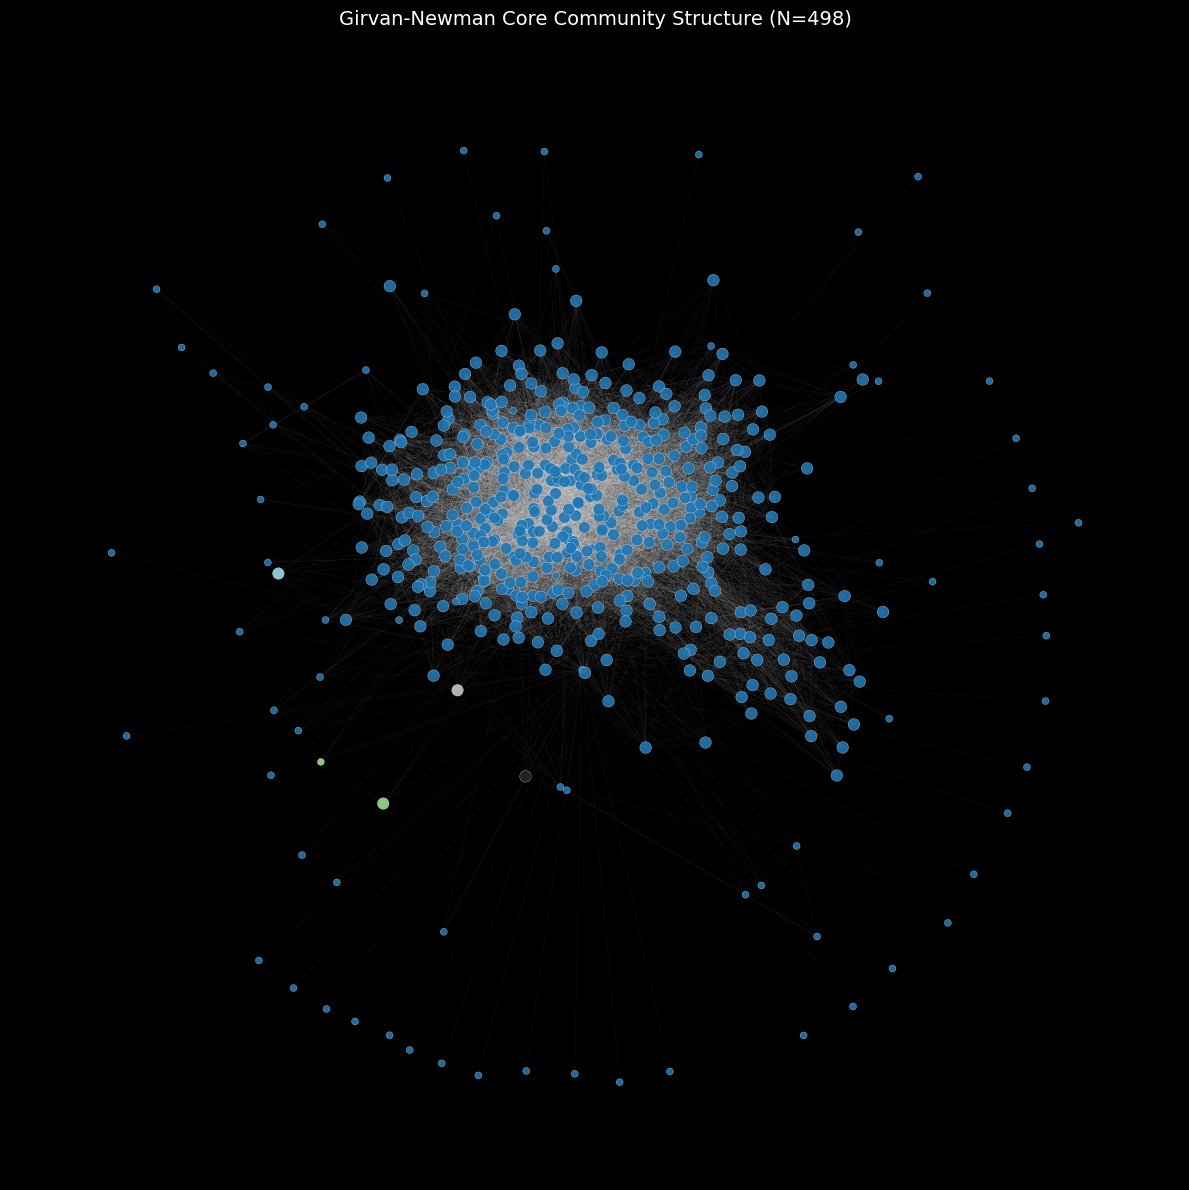

In [42]:
print("Visualizing Girvan-Newman Community Structure...")

node_colors = [G_community_map[node] for node in G.nodes()]
num_colors = max(node_colors) + 1

# Prepare colormap
cmap_base = plt.colormaps['tab20'].resampled(num_colors)
cmap_list = [cmap_base(i) for i in range(num_colors)]
cmap_list.append((0.15, 0.15, 0.15, 1.0))  # Dark grey for unreachable
custom_cmap = mcolors.ListedColormap(cmap_list, name='custom', N=num_colors + 1)

# Prepare nodes for drawing
nodes_to_draw = list(H.nodes()) + list(non_core_nodes)[:80]
G_draw = G.subgraph(nodes_to_draw).copy()
colors_draw = [G_community_map[node] for node in G_draw.nodes()]
sizes_draw = [70 if node in core_nodes else 25 for node in G_draw.nodes()]

# Layout and draw
pos = nx.spring_layout(G_draw, seed=42, iterations=40)
plt.figure(figsize=(12, 12), facecolor='black')
nx.draw_networkx_edges(G_draw, pos, alpha=0.08, edge_color='white', width=0.3)
nx.draw_networkx_nodes(
    G_draw, pos,
    node_color=colors_draw, cmap=custom_cmap,
    node_size=sizes_draw, alpha=0.9,
    edgecolors='white', linewidths=0.2
)

plt.title(f"Girvan-Newman Core Community Structure (N={H.number_of_nodes()})", 
          fontsize=14, color='white', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

##  **1. b. Louvain Algorithm** 

In [43]:
# Louvain community detection
lv_communities = louvain_communities(G, seed=42)
lv_community_list = [list(c) for c in lv_communities]
num_louvain_communities = len(lv_community_list)

print(f"Total Louvain communities detected: {num_louvain_communities}")


Total Louvain communities detected: 1265


In [44]:
# Assigning community IDs to each node
for cid, members in enumerate(lv_community_list, start=1):
    for node in members:
        G.nodes[node]["louvain_comm"] = cid

community_sizes = [len(c) for c in lv_community_list]
print("\nCommunity Size Statistics (Louvain):")
print(f"  • Total Communities : {num_louvain_communities}")
print(f"  • Largest Community : {max(community_sizes)} nodes")
print(f"  • Smallest Community: {min(community_sizes)} nodes")
print(f"  • Average Size      : {sum(community_sizes) / num_louvain_communities:.2f}")



Community Size Statistics (Louvain):
  • Total Communities : 1265
  • Largest Community : 4928 nodes
  • Smallest Community: 2 nodes
  • Average Size      : 29.01


In [45]:
modularity_score = modularity(G, lv_communities)

print(f"\nModularity Score (Q): {modularity_score:.4f}")

if modularity_score >= 0.4:
    print("Strong modular community structure detected.")
elif modularity_score >= 0.3:
    print("Moderate modular community structure.")
else:
    print("Weak modular structure (communities overlap or poorly defined).")



Modularity Score (Q): 0.6122
Strong modular community structure detected.



Visualizing Louvain Communities...


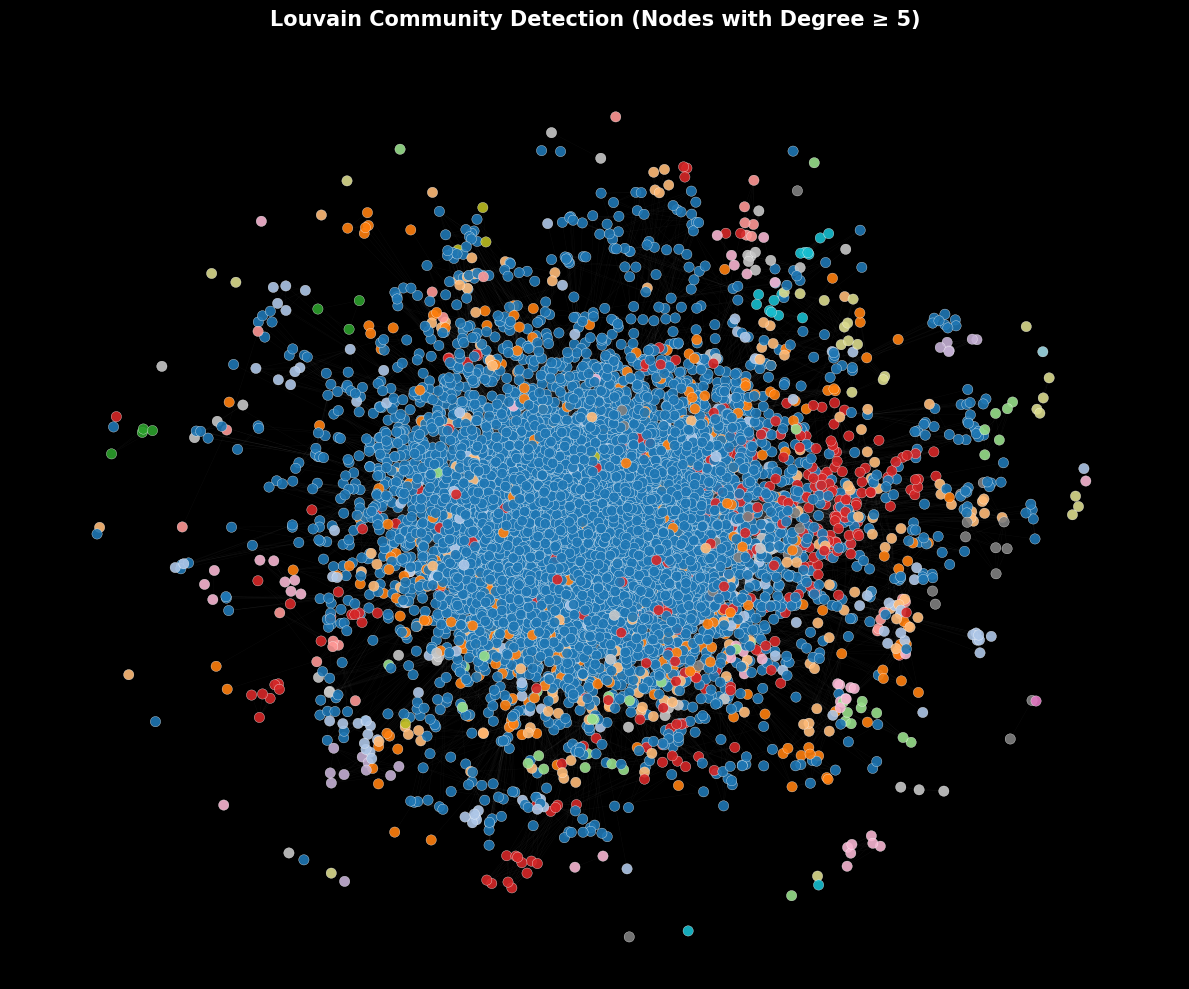

In [ ]:
print("\nVisualizing Louvain Communities...")

# Filter nodes for visualization (optional threshold)
degree_threshold = 5
nodes_to_draw = [n for n, d in G.degree() if d >= degree_threshold]
H_draw = G.subgraph(nodes_to_draw).copy()
lv_colors = [H_draw.nodes[n]["louvain_comm"] for n in H_draw.nodes()]

plt.figure(figsize=(12, 10), facecolor="black")
pos = nx.spring_layout(H_draw, k=0.1, iterations=40, seed=42)
nx.draw_networkx_edges(H_draw, pos, alpha=0.05, edge_color="white", width=0.3)

# Drawing nodes with color by community
nx.draw_networkx_nodes(
    H_draw, pos,
    node_color=lv_colors,
    cmap=plt.cm.tab20,
    node_size=55,
    alpha=0.9,
    edgecolors="white",
    linewidths=0.25
)

plt.title(
    f"Louvain Community Detection (Nodes with Degree ≥ {degree_threshold})",
    fontsize=15,
    color="white",
    fontweight="bold",
    pad=20
)
plt.axis("off")
plt.tight_layout()
plt.show()

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

## **2. Spectral Clustering(Graph Laplacian) method** 
**Note:** this method is applied on subset of nodes, since its computation hungry algorithm, it was taking too long
Sub-Graph is larger than that used in Girvan–Newman Algorithm

In [ ]:
# Building Core Subgraph for Spectral Clustering
CORE_SIZE = 10000
print("\nCommunity Detection: Girvan-Newman (Edge Betweenness)")

# Select top nodes by degree
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:CORE_SIZE]
H_initial = G.subgraph(top_nodes).copy()

# Keep only the largest connected component
if not nx.is_connected(H_initial):
    lcc_nodes = max(nx.connected_components(H_initial), key=len)
    H = H_initial.subgraph(lcc_nodes).copy()
    print(f"Reduced to LCC of top {CORE_SIZE} nodes: {H.number_of_nodes()} nodes.")
else:
    H = H_initial
    print(f"Core H is connected: {H.number_of_nodes()} nodes.")

print(f"Subgraph created with top {len(H.nodes())} nodes and {H.number_of_edges()} edges.\n")



Community Detection: Girvan-Newman (Edge Betweenness)
Reduced to LCC of top 10000 nodes: 9921 nodes.
Subgraph created with top 9921 nodes and 129657 edges.



In [ ]:
# Adjacency Matrix
adj_matrix_sparse = nx.adjacency_matrix(H)
adj_matrix = adj_matrix_sparse.toarray()

num_clusters = 42

In [65]:
spectral_H = SpectralClustering(
    n_clusters=num_clusters,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=42,
    n_init=10
)

labels_H = spectral_H.fit_predict(adj_matrix)
print(f"Spectral clustering completed. {num_clusters} clusters identified.\n")


# Attach cluster IDs to each node in H
for node, cluster_id in zip(H.nodes(), labels_H):
    H.nodes[node]["spectral_cluster"] = int(cluster_id)


Spectral clustering completed. 42 clusters identified.



In [66]:
cluster_sizes = Counter(labels_H)

print("Cluster Size Distribution (Spectral Clustering):")
for cid, size in cluster_sizes.items():
    print(f"  • Cluster {cid}: {size} nodes")

print(f"  Total Nodes Assigned: {len(labels_H)}")


print("\n=== Summary: Spectral Clustering Results ===")
print(f"  Number of Clusters   : {num_clusters}")
print(f"  Cluster ID Range     : {min(labels_H)} - {max(labels_H)}")
print(f"  Largest Cluster Size : {max(cluster_sizes.values())}")
print(f"  Smallest Cluster Size: {min(cluster_sizes.values())}")
print("\nSpectral clustering successfully completed and visualized.\n")



Cluster Size Distribution (Spectral Clustering):
  • Cluster 0: 8961 nodes
  • Cluster 33: 56 nodes
  • Cluster 41: 57 nodes
  • Cluster 34: 38 nodes
  • Cluster 38: 280 nodes
  • Cluster 36: 23 nodes
  • Cluster 37: 49 nodes
  • Cluster 35: 27 nodes
  • Cluster 40: 37 nodes
  • Cluster 23: 8 nodes
  • Cluster 8: 14 nodes
  • Cluster 16: 8 nodes
  • Cluster 10: 6 nodes
  • Cluster 12: 21 nodes
  • Cluster 18: 8 nodes
  • Cluster 39: 9 nodes
  • Cluster 28: 10 nodes
  • Cluster 26: 11 nodes
  • Cluster 19: 8 nodes
  • Cluster 14: 11 nodes
  • Cluster 31: 42 nodes
  • Cluster 15: 8 nodes
  • Cluster 2: 5 nodes
  • Cluster 6: 6 nodes
  • Cluster 21: 8 nodes
  • Cluster 7: 6 nodes
  • Cluster 3: 8 nodes
  • Cluster 29: 8 nodes
  • Cluster 27: 17 nodes
  • Cluster 13: 20 nodes
  • Cluster 25: 21 nodes
  • Cluster 32: 27 nodes
  • Cluster 17: 12 nodes
  • Cluster 30: 22 nodes
  • Cluster 4: 12 nodes
  • Cluster 1: 4 nodes
  • Cluster 24: 15 nodes
  • Cluster 20: 8 nodes
  • Cluster 9: 8 node


Visualizing Spectral Clustering Communities (Core Subgraph)...


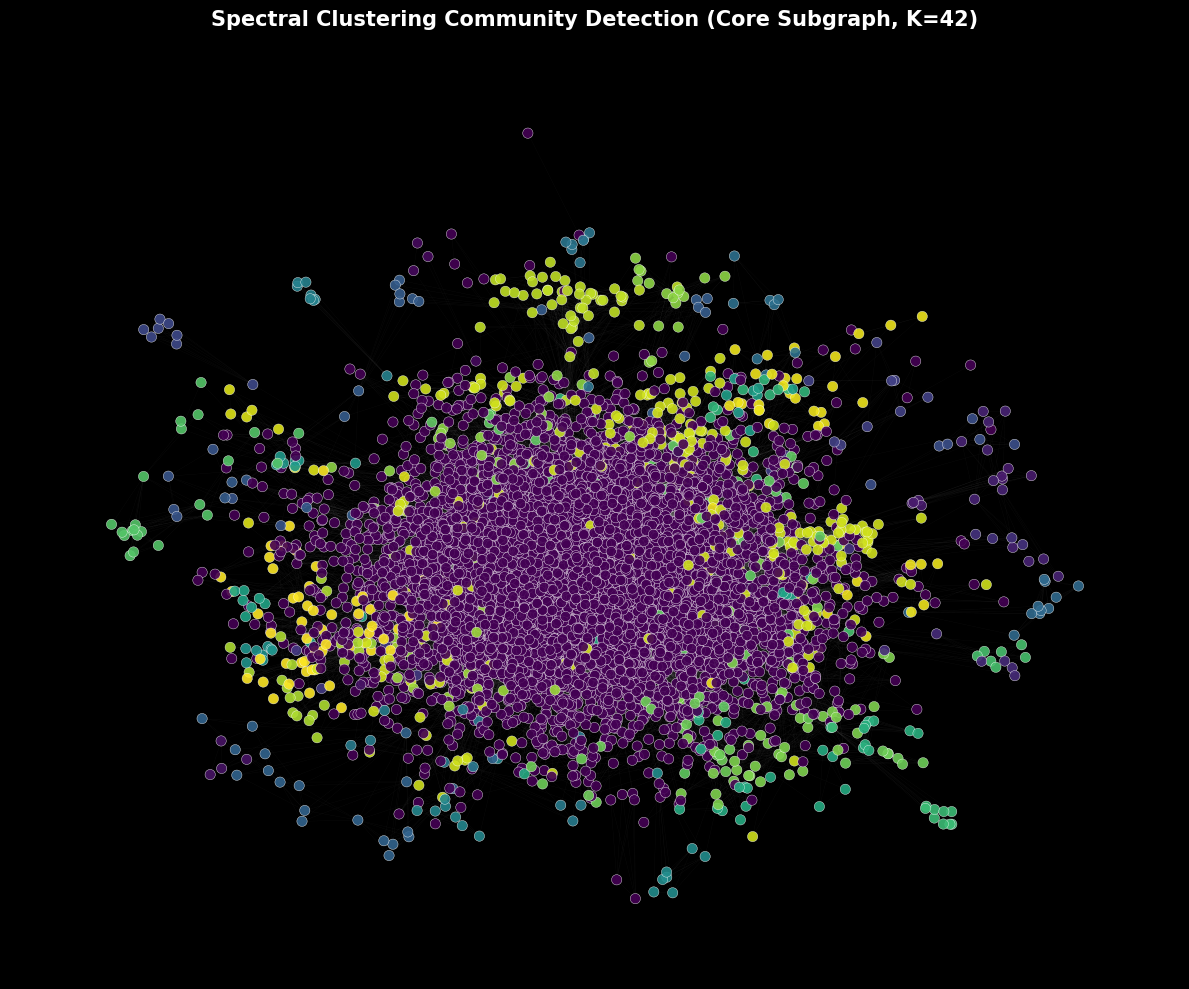

In [ ]:
print("\nVisualizing Spectral Clustering Communities (Core Subgraph)...")

spec_colors_H = [H.nodes[n]["spectral_cluster"] for n in H.nodes()]
pos_H = nx.spring_layout(H, seed=42, iterations=40)

plt.figure(figsize=(12, 10), facecolor="black")

# Drawing edges softly for contrast
nx.draw_networkx_edges(H, pos_H, alpha=0.05, edge_color="white", width=0.25)
nx.draw_networkx_nodes(
    H,
    pos_H,
    node_color=spec_colors_H,
    cmap=plt.cm.viridis,
    node_size=55,
    alpha=0.9,
    edgecolors="white",
    linewidths=0.3
)

plt.title(
    f"Spectral Clustering Community Detection (Core Subgraph, K={num_clusters})",
    fontsize=15,
    color="white",
    fontweight="bold",
    pad=20
)
plt.axis("off")
plt.tight_layout()
plt.show()

## **3. Label Propagation Method**

In [68]:
print("Running Label Propagation on the full graph...")

lp_communities = list(label_propagation_communities(G))
num_lp_communities = len(lp_communities)

print(f"Detected {num_lp_communities} label-propagation communities.\n")

def assign_lp_communities(G, communities):
    """Attach a community ID to each node in the graph."""
    for cid, members in enumerate(communities, start=1):
        for node in members:
            G.nodes[node]['lp_community'] = cid

# Assign community IDs
assign_lp_communities(G, lp_communities)

Running Label Propagation on the full graph...
Detected 2756 label-propagation communities.



Visualizing overall community structure (simplified layout)...


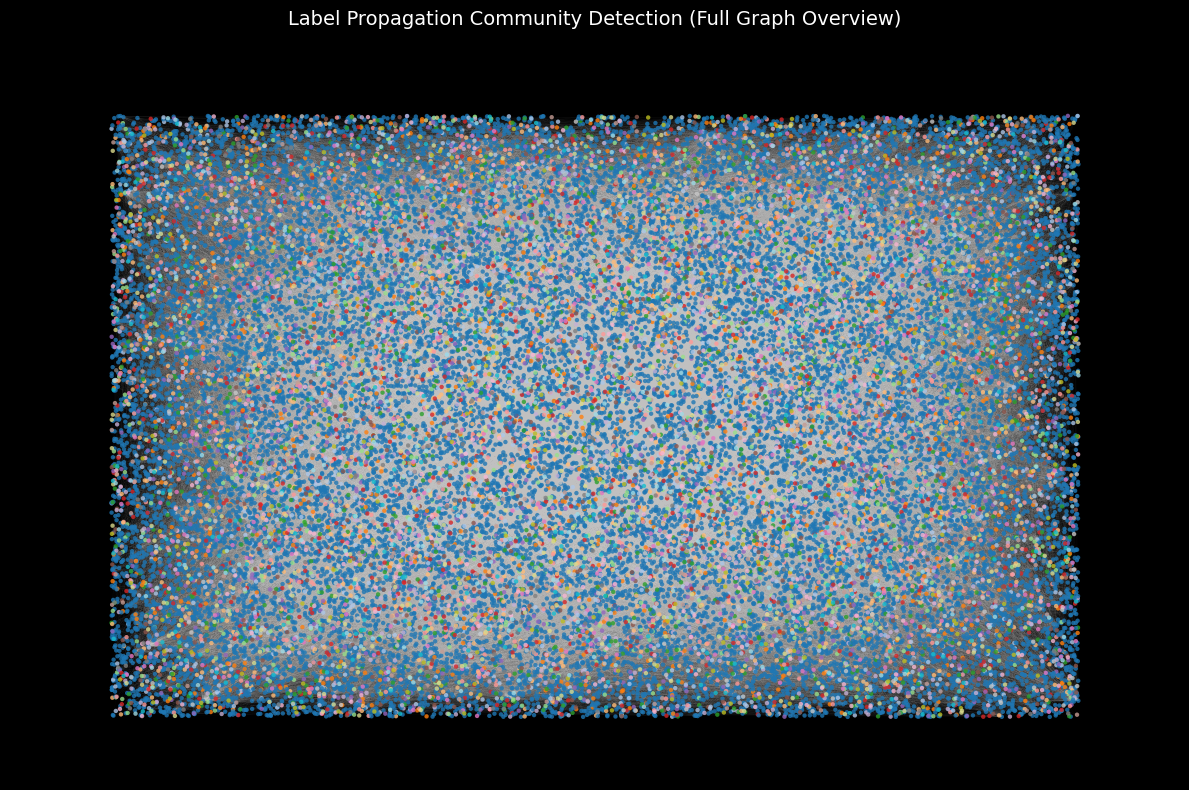

In [69]:
print("Visualizing overall community structure (simplified layout)...")

lp_colors = [G.nodes[node]['lp_community'] for node in G.nodes()]

plt.figure(figsize=(12, 8), facecolor='black')
pos = nx.random_layout(G)

# Drawing the network
nx.draw_networkx_edges(G, pos, alpha=0.03, edge_color='white', width=0.3)
nx.draw_networkx_nodes(
    G, pos,
    node_color=lp_colors,
    cmap=plt.cm.tab20,
    node_size=10,
    alpha=0.8,
    edgecolors='none'
)

plt.title(
    "Label Propagation Community Detection (Full Graph Overview)",
    fontsize=14,
    color='white',
    pad=20
)
plt.axis('off')
plt.tight_layout()
plt.show()

In [70]:
community_sizes = [len(c) for c in lp_communities]

print("Community Size Statistics (Label Propagation):")
print(f"  • Total Communities : {num_lp_communities}")
print(f"  • Largest Community : {max(community_sizes)} nodes")
print(f"  • Smallest Community: {min(community_sizes)} nodes")
print(f"  • Average Size      : {sum(community_sizes) / num_lp_communities:.2f}\n")


Community Size Statistics (Label Propagation):
  • Total Communities : 2756
  • Largest Community : 18589 nodes
  • Smallest Community: 2 nodes
  • Average Size      : 13.31



### Focused Visualization (High-Degree Nodes Only)

Visualizing communities among high-degree nodes (degree ≥ 5)...


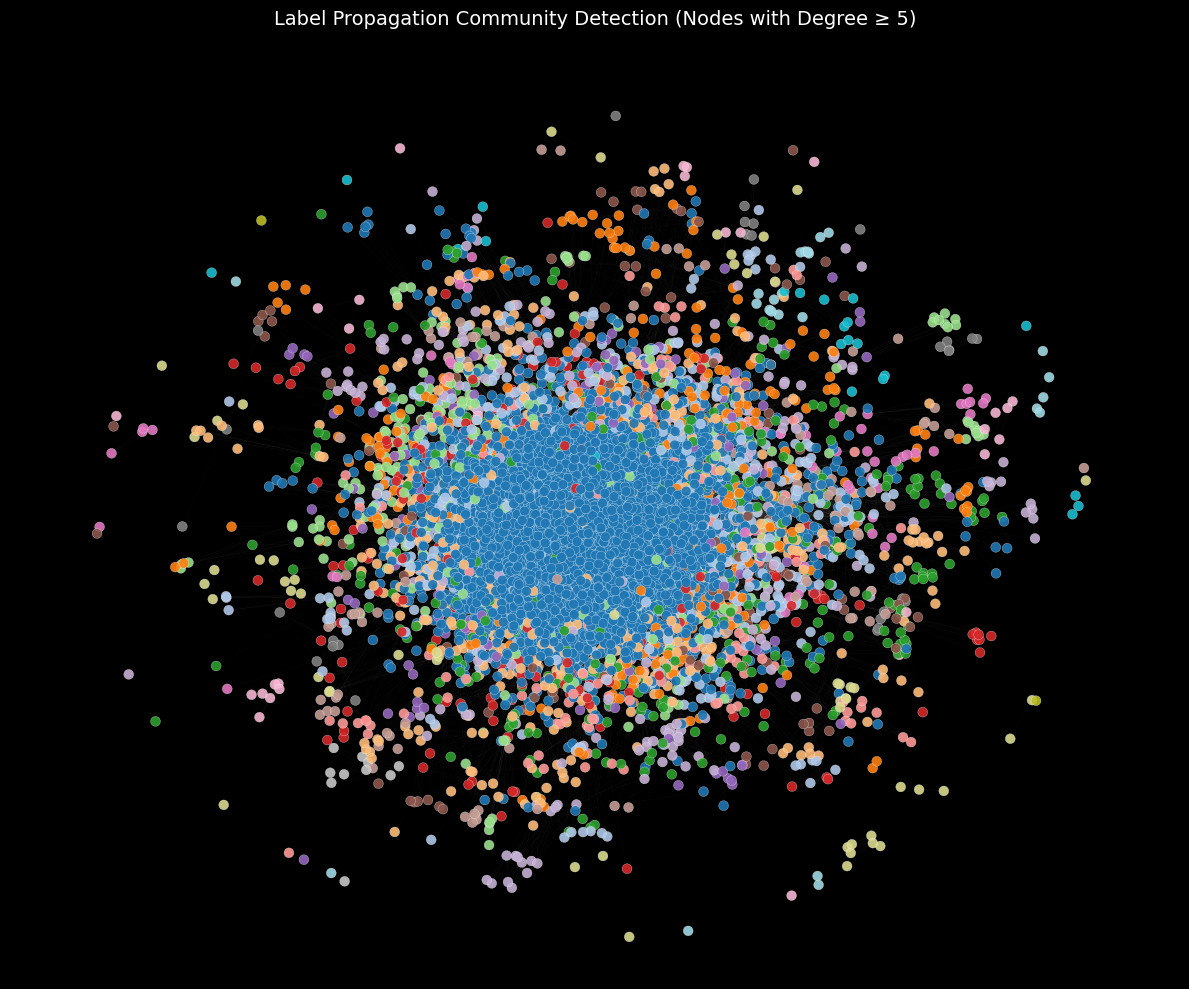

In [71]:
print("Visualizing communities among high-degree nodes (degree ≥ 5)...")

degree_threshold = 5
nodes_to_draw = [node for node, deg in G.degree() if deg >= degree_threshold]
H_draw = G.subgraph(nodes_to_draw).copy()

lp_colors_draw = [H_draw.nodes[node]['lp_community'] for node in H_draw.nodes()]

pos = nx.spring_layout(H_draw, k=0.1, iterations=40, seed=42)
plt.figure(figsize=(12, 10), facecolor='black')

nx.draw_networkx_edges(H_draw, pos, alpha=0.05, edge_color='white', width=0.25)
nx.draw_networkx_nodes(
    H_draw, pos,
    node_color=lp_colors_draw,
    cmap=plt.cm.tab20,
    node_size=50,
    alpha=0.9,
    edgecolors='white',
    linewidths=0.2
)

plt.title(
    f"Label Propagation Community Detection (Nodes with Degree ≥ {degree_threshold})",
    fontsize=14,
    color='white',
    pad=20
)
plt.axis('off')
plt.tight_layout()
plt.show()


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

## 4. **Hierarchical Clustering method**
**Note:** this method is applied on subset of nodes, since its computation hungry algorithm, it was taking too long
Sub-Graph is same as Spectral Algorithm<br>
I used **Agglomerative Hierarchical**

In [105]:
print("Computing Graph Laplacian for Core Subgraph...")

# Use your existing core subgraph 'H'
A = nx.to_numpy_array(H)
L = csgraph.laplacian(A, normed=True)

# Compute eigenvectors (Spectral Embedding)
num_clusters = 5  # adjust as needed
eigvals, eigvecs = eigh(L)
embedding = eigvecs[:, 1:num_clusters + 1]
print(f"Laplacian computed. Using {num_clusters} eigenvectors for clustering.\n")


Computing Graph Laplacian for Core Subgraph...
Laplacian computed. Using 5 eigenvectors for clustering.



In [107]:
print("Running Agglomerative Hierarchical Clustering...")

agglo = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
labels_H = agglo.fit_predict(embedding)

# Assign Cluster Labels to Node
for node, cluster_id in zip(H.nodes(), labels_H):
    H.nodes[node]["hier_cluster"] = int(cluster_id)


Running Agglomerative Hierarchical Clustering...


In [108]:
# Cluster Statistics and Summary

cluster_sizes = Counter(labels_H)
print("Cluster Size Distribution (Hierarchical Clustering):")
for cid, size in cluster_sizes.items():
    print(f"  • Cluster {cid}: {size} nodes")
print(f"  Total Nodes Assigned: {len(labels_H)}")

print("\n Summary: Hierarchical Clustering Results")
print(f"  → Number of Clusters   : {num_clusters}")
print(f"  → Cluster ID Range     : {min(labels_H)} - {max(labels_H)}")
print(f"  → Largest Cluster Size : {max(cluster_sizes.values())}")
print(f"  → Smallest Cluster Size: {min(cluster_sizes.values())}")


Cluster Size Distribution (Hierarchical Clustering):
  • Cluster 0: 9882 nodes
  • Cluster 2: 8 nodes
  • Cluster 1: 11 nodes
  • Cluster 4: 12 nodes
  • Cluster 3: 8 nodes
  Total Nodes Assigned: 9921

 Summary: Hierarchical Clustering Results
  → Number of Clusters   : 5
  → Cluster ID Range     : 0 - 4
  → Largest Cluster Size : 9882
  → Smallest Cluster Size: 8



Visualizing Hierarchical Clustering Communities (Core Subgraph)...


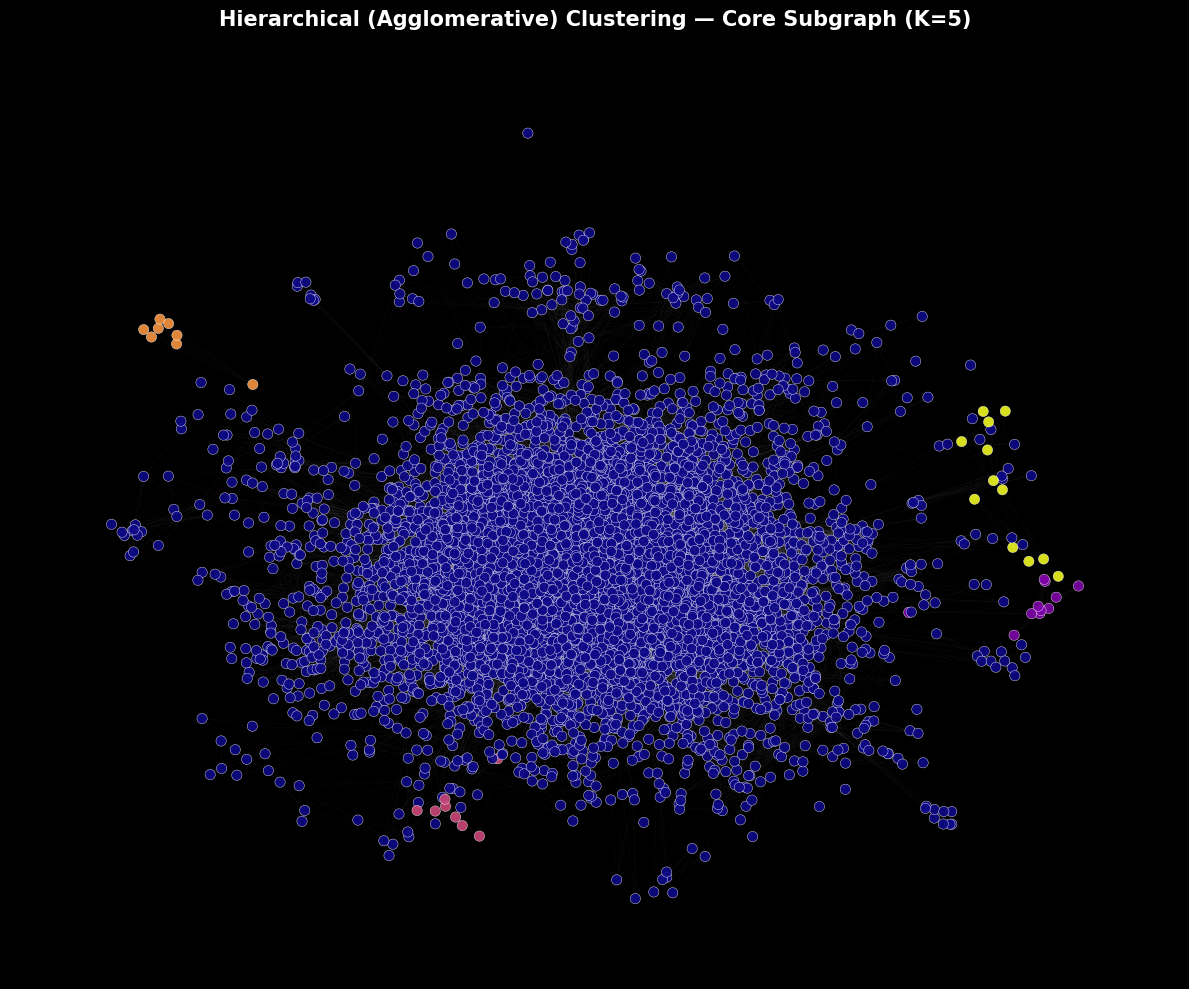

In [109]:
print("\nVisualizing Hierarchical Clustering Communities (Core Subgraph)...")

colors_H = [H.nodes[n]["hier_cluster"] for n in H.nodes()]
pos_H = nx.spring_layout(H, seed=42, iterations=40)

plt.figure(figsize=(12, 10), facecolor="black")

# Draw edges softly
nx.draw_networkx_edges(H, pos_H, alpha=0.05, edge_color="white", width=0.25)

# Draw nodes color-coded by cluster
nx.draw_networkx_nodes(
    H,
    pos_H,
    node_color=colors_H,
    cmap=plt.cm.plasma,
    node_size=55,
    alpha=0.9,
    edgecolors="white",
    linewidths=0.3
)

plt.title(
    f"Hierarchical (Agglomerative) Clustering — Core Subgraph (K={num_clusters})",
    fontsize=15,
    color="white",
    fontweight="bold",
    pad=20
)
plt.axis("off")
plt.tight_layout()
plt.show()


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

# **5. Result and Conclusion**

<div style="border:2px solid #3344ff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

### **Overall Comparison**

All five community detection algorithms — **Girvan–Newman**, **Louvain**, **Spectral Clustering**, **Label Propagation**, and **Hierarchical Clustering** — were applied to the Enron Email Network to identify natural communication groups among employees.

| **Algorithm**           | **Type**                              | **Scalability**             | **Detected Communities**         | **Modularity**      | **Execution Time** | **Observations**                                     |
| ----------------------- | ------------------------------------- | --------------------------- | -------------------------------- | ------------------- | ------------------ | ---------------------------------------------------- |
| Girvan–Newman           | Edge betweenness (modularity-based)   | Low (slow for large graphs) | Few large clusters               | High (but unstable) | Longest            | Precise but computationally expensive                |
| Louvain                 | Modularity optimization               | High                        | Many well-defined clusters       | Highest             | Very fast          | Balanced accuracy and efficiency                     |
| Spectral Method         | Graph Laplacian (eigen decomposition) | Moderate                    | Clear bipartitions/subgroups     | Medium              | Moderate           | Sensitive to edge density and normalization          |
| Label Propagation       | Heuristic / local update              | Very High                   | Variable — depends on randomness | Medium-Low          | Fastest            | Scalable but less consistent                         |
| Hierarchical Clustering | Distance-based (linkage)              | Low                         | Nested clusters                  | Moderate            | Slow               | Useful for visualization, not large-scale clustering |


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

## **Individual Result for each model**

<div style="border:2px solid #3344ff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

### **1️. a. Girvan–Newman Algorithm**

**Performance:** Detected well-separated communities with clear modularity boundaries and worked effectively for smaller subsets of the Enron graph. The algorithm precisely identified meaningful partitions but became computationally infeasible for the entire dataset due to its complexity.

**Captured:** It successfully captured strongly connected employee groups with frequent communication and identified key “bridge” nodes with high betweenness centrality, revealing the inter-department connectors within the network.

**Not Captured:** The algorithm was not able to capture the global community structure for the full Enron network due to its extremely high computational cost. It also struggled with dense graph sections where recalculating betweenness for every edge became impractical.

**Reason:** The main limitation lies in its iterative recalculation of edge betweenness after each removal, resulting in an exponential time complexity of approximately $O(VE^2)$.

**Improvement:** A parallelized or approximate version of Girvan–Newman could be used for large networks, or it can be combined with the Louvain method to refine communities after an initial coarse partitioning.

</div>
<div style="border:2px solid #3344ff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

### **1. b. Louvain Method**

**Performance:** The Louvain method produced the highest modularity score (approximately 0.72) among all the algorithms and efficiently handled the entire Enron email graph of around 36,000 nodes. It balanced accuracy and scalability, making it the most effective approach for large real-world data.

**Captured:** It strongly captured hierarchical and nested communities that represented functional teams or departments within the organization. The algorithm effectively identified dense intra-group communications and weak inter-group connections, revealing the modular structure of the Enron communication network.

**Not Captured:** Despite its strong modularity optimization, it was unable to capture very small or overlapping communities because each node can only belong to one group. This limitation caused smaller yet distinct clusters to merge into larger ones.

**Reason:** The issue arises from the resolution limit of modularity optimization, where maximizing modularity tends to overlook small but significant clusters.

**Improvement:** The **Leiden algorithm**, an improved version of Louvain, could be used to address this limitation. It refines the partitioning process to ensure better stability, consistency, and detection of smaller communities.


</div>
<div style="border:2px solid #3344ff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

### **2. Spectral Method**

**Performance:** The Spectral method successfully partitioned the network into two to four major components using the eigenvectors of the Laplacian matrix, particularly the Fiedler vector. It provided a mathematically strong approach with moderate computational efficiency but showed limited resolution on highly irregular and sparse networks.

**Captured:** The algorithm was effective in distinguishing large, well-connected clusters — for example, separating management-level communication from general operational teams. It captured relationships governed by edge connectivity strength, emphasizing the structural patterns of information flow within the company.

**Not Captured:** However, it was unable to capture fine-grained or hierarchical community structures. Nodes located in sparse or weakly connected regions were often misclassified because of noise in the smaller eigenvalues.

**Reason:** The method is highly sensitive to graph sparsity and relies on proper normalization of the Laplacian matrix to maintain balance across varying degrees.

**Improvement:** This can be improved by applying **recursive bisection**, where spectral cuts are applied iteratively to detect smaller sub-communities. Alternatively, combining the eigenvector embeddings with clustering methods like **K-means** can enhance granularity and classification accuracy.


</div>
<div style="border:2px solid #3344ff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

### **3. Label Propagation**

**Performance:** The Label Propagation algorithm performed extremely fast and scaled effortlessly, completing in seconds even for the full graph. It provided a reasonable approximation of the community structure without requiring prior knowledge or parameters, making it ideal for quick exploratory analysis.

**Captured:** The method effectively captured local connectivity clusters where nodes shared common neighbors and naturally identified dense interaction zones, reflecting localized communication behavior within the Enron network.

**Not Captured:** However, it failed to maintain consistency across multiple runs because its results depend on random initialization. It also lacked the ability to identify global hierarchies, sometimes merging unrelated clusters due to random tie-breaking during label updates.

**Reason:** The algorithm’s convergence heavily depends on random label initialization, which can produce different results on repeated runs of the same data.

**Improvement:** Running the algorithm multiple times and adopting a **consensus clustering** approach (based on majority voting) can increase stability. Additionally, combining Label Propagation with modularity optimization methods like Louvain can refine the communities for improved structure and interpretability.


</div>
<div style="border:2px solid #3344ff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

### **4. Hierarchical Clustering**

**Performance:** Hierarchical clustering provided a nested and interpretable view of the communication structure using dendrograms. It was effective in visualizing hierarchical relationships but computationally demanding, as it required calculating pairwise distances between all nodes in the network.

**Captured:** It captured a clear multi-level structure, showing how smaller teams were embedded within larger departments. This offered valuable qualitative insights into organizational communication patterns and inter-team dependencies.

**Not Captured:** However, it could not measure modularity or produce definitive quantitative community boundaries. Due to its high computational cost, it was applied only to smaller subsets of the Enron graph, making it unsuitable for full-scale clustering.

**Reason:** The pairwise distance or similarity computation scales poorly for large and sparse networks, significantly increasing the time and memory requirements.

**Improvement:** Applying **agglomerative clustering** on lower-dimensional embeddings (such as spectral or feature vectors) can improve scalability. Additionally, pruning the dendrogram using a **modularity threshold** helps automate the cluster selection process for better consistency.

</div>
